In [165]:
%matplotlib notebook
import hyperspy.api as hs

In [166]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import scipy.io as sio
from scipy import signal
import numpy.linalg

In [177]:
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'

In [3]:
import csv

file_HAADF = [image for image in os.listdir('/srv/home/chenyu/DEbackup/092219/S2/') if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open('/srv/home/chenyu/DEbackup/092219/S2/' +  file_HAADF) as csvfile:
    file=csv.reader(open('/srv/home/chenyu/DEbackup/092219/S2/'+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))

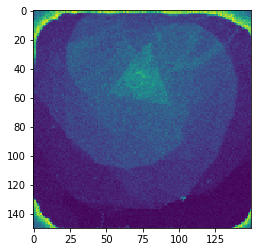

In [4]:
plt.imshow(HAADFarray)

In [178]:
rx = 150
ry = 150
dataset = np.zeros((rx,ry,300,300))
PACBED = np.zeros((1024,1024))
for irow in range(rx):
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'S2_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        PACBED = PACBED + Sample
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        dataset[irow,icol,:,:] = np.sqrt(resized)

In [179]:
s = hs.signals.Signal2D(data=dataset)

<IPython.core.display.Javascript object>


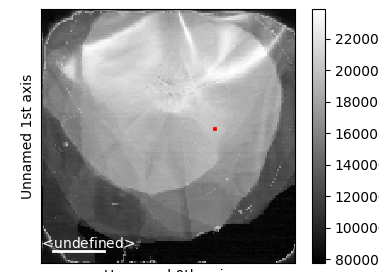

<IPython.core.display.Javascript object>


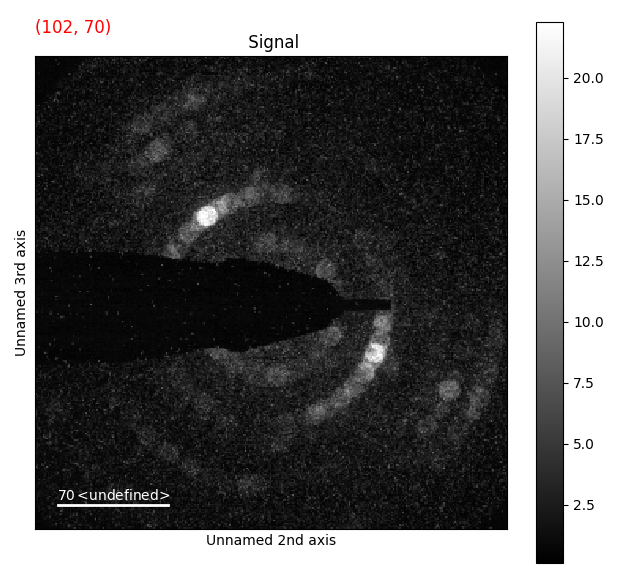

In [181]:
s.transpose()
s.plot()

## ROI 2

In [9]:
# Pick up a subset
rx = 150
ry = 150
dataset = np.zeros((44,66,300,300))
PACBED = np.zeros((1024,1024))
for irow in range(91,135):
    for icol in range(8,74):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'S2_'+format(nSample,'05')+'.npy')
        PACBED = PACBED + Sample
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        dataset[irow-91,icol-8,:,:] = resized

<IPython.core.display.Javascript object>


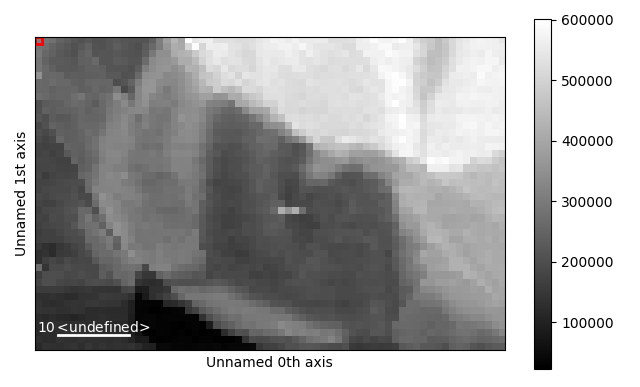

<IPython.core.display.Javascript object>


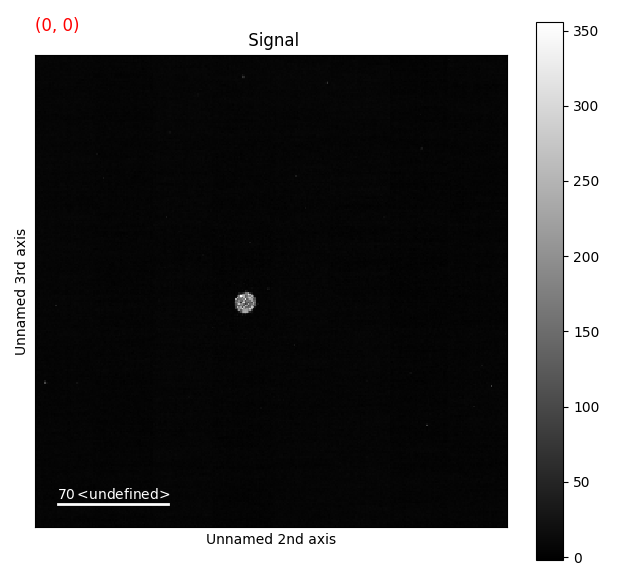

In [11]:
# dataset = np.einsum('klij->lkij', dataset) # swap the first to dimensions for better visulization
s = hs.signals.Signal2D(data=dataset)
s.transpose()
s.plot()

In [42]:
# Register all frame after downsampling to 300x300 per frame
rx = 150
ry = 150
refpath = '/srv/home/chenyu/DEbackup/092219/S0_10kX/npy/'
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'
dataset = np.zeros((44,66,300,300))
dataset_ref = np.zeros((44,66,300,300))

# load reference frame
irow = 91
icol = 8
nSample = irow * rx + icol + 1;
Sample_ref = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
Sample_ref = cv2.resize(Sample_ref, (300,300), interpolation = cv2.INTER_AREA)
num_rows, num_cols = Sample_ref.shape[:2]

# loop over all beam positions in the ROI
for irow in range(91,135):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(8,74):
        nSample = irow * rx + icol + 1;
        Sample = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
        Sample = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        # use fftshift to move xcorr beam to center
        corr = np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(Sample))*np.fft.fft2(Sample_ref))).real
        y, x = np.unravel_index(np.argmax(corr), corr.shape)
        x = x - 150
        y = y - 150
        translation_matrix = np.float32([[1,0,x],[0,1,y]])
        # Also keep all the blank scan frames inside a datacube so that one can check whether the registration is correct
        dataset_ref[irow-91,icol-8,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))
        
        # load CBED with sample and correct for the shift
        Sample = np.load(path + 'S2_'+format(nSample,'05')+'.npy')
        Sample = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        dataset[irow-91,icol-8,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))

Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130


In [44]:
np.save('/srv/home/chenyu/DEbackup/092219/S2/ROI2_registered.npy',dataset)
np.save('/srv/home/chenyu/DEbackup/092219/S2/ROI2_ref_registered.npy',dataset_ref)

<IPython.core.display.Javascript object>


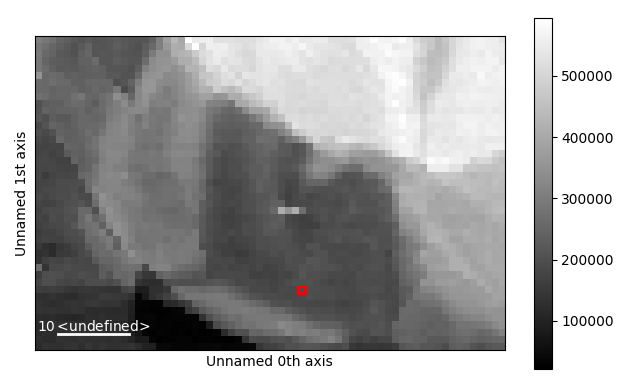

<IPython.core.display.Javascript object>


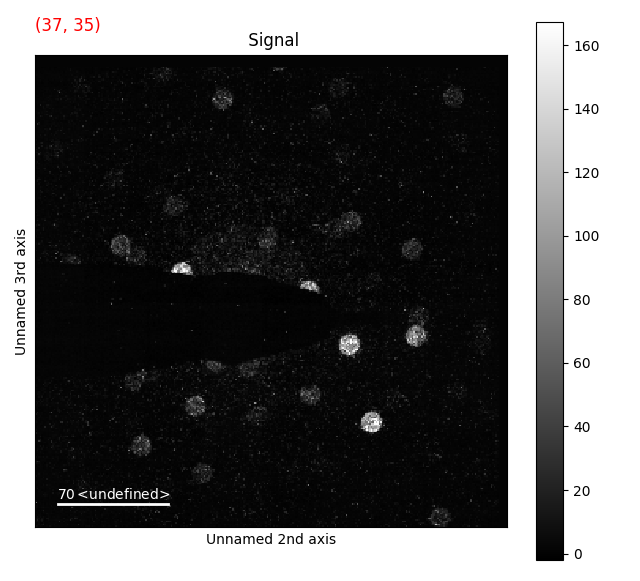

In [167]:
dataset = np.load('/srv/home/chenyu/DEbackup/092219/S2/ROI2_registered.npy')
s = hs.signals.Signal2D(data=dataset)
s.transpose()
s.plot()

<IPython.core.display.Javascript object>


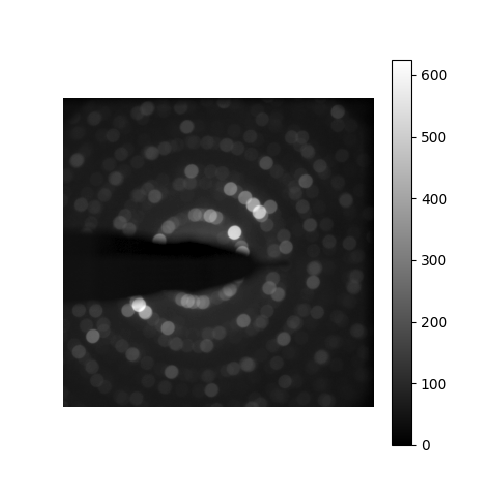

(-0.5, 299.5, 299.5, -0.5)

In [49]:
dataset = np.load('/srv/home/chenyu/DEbackup/092219/S2/ROI2_registered.npy')
PACBED = np.sum(np.sum(dataset,axis=0),axis=0)
fig = plt.figure(figsize=(5,5))
PACBED[PACBED<0] = 0
plt.imshow(np.sqrt(PACBED))
plt.colorbar()
plt.axis('off')

<IPython.core.display.Javascript object>


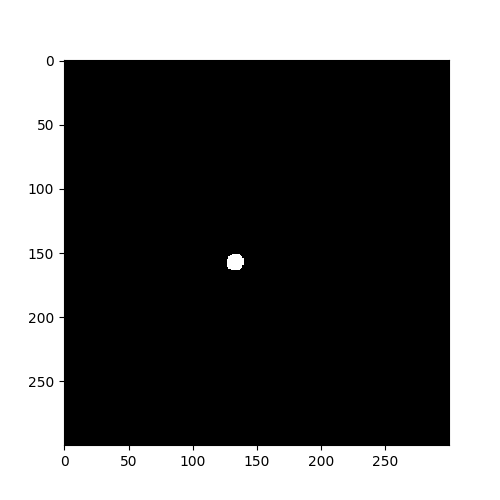

In [48]:
# Try simple cross correlation
# extract xcorr mask
dataset_ref = np.load('/srv/home/chenyu/DEbackup/092219/S2/ROI2_ref_registered.npy')
mask = np.sum(np.sum(dataset_ref,axis=0),axis=0)
# plt.imshow(mask)
# plt.colorbar()
mask = np.heaviside(mask-50000,1)

# Can generate a ring-shaped mask using morphological gradient
# kernel = np.ones((2,2),np.uint8)
# mask = cv2.morphologyEx(mask,cv2.MORPH_GRADIENT,kernel)
# mask = mask[530:630,500:600]
fig = plt.figure(figsize=(5,5))
plt.imshow(mask)

<IPython.core.display.Javascript object>


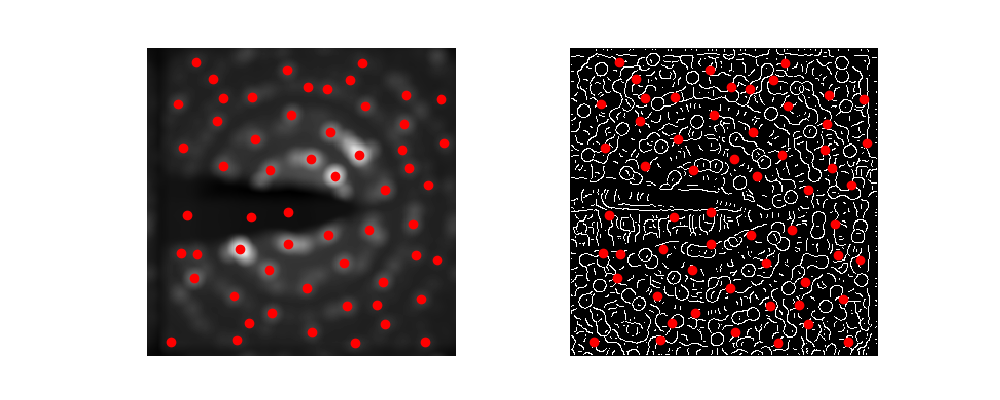

(-0.5, 299.5, 299.5, -0.5)

In [59]:
mask_pad = mask
PACBED_pad = PACBED
# mask_pad = np.pad(mask_pad,[(100,100),(100,100)],mode='constant')
# PACBED_pad = np.pad(PACBED_pad,[(100,100),(100,100)],mode = 'constant')

corr = (np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(mask_pad))*np.fft.fft2(PACBED_pad)))).real

fig = plt.figure(figsize=(10,4))

fig.add_subplot(121)
plt.imshow(np.sqrt(corr))
image_max = ndi.maximum_filter(corr, size=5)
coordinates = peak_local_max(corr, min_distance=10,threshold_rel=0.00)
plt.scatter(coordinates[:,1],coordinates[:,0],c='r')
plt.axis('off')

fig.add_subplot(122)
plt.imshow(np.sqrt(PACBED))
# There is a constant shift on the detected peak positions, basically because the mask is not centered
plt.scatter(coordinates[:,1],coordinates[:,0],c='r')
coordinates_total = coordinates
plt.axis('off')

## ROI1

In [5]:
# Pick up a subset
rx = 150
ry = 150
dataset = np.zeros((110,16,300,300))
PACBED = np.zeros((1024,1024))
for irow in range(110):
    for icol in range(130,145):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'S2_'+format(nSample,'05')+'.npy')
        PACBED = PACBED + Sample
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        dataset[irow,icol-130,:,:] = resized

<IPython.core.display.Javascript object>


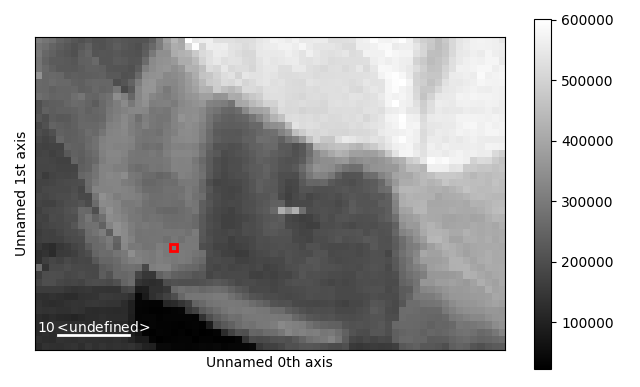

<IPython.core.display.Javascript object>


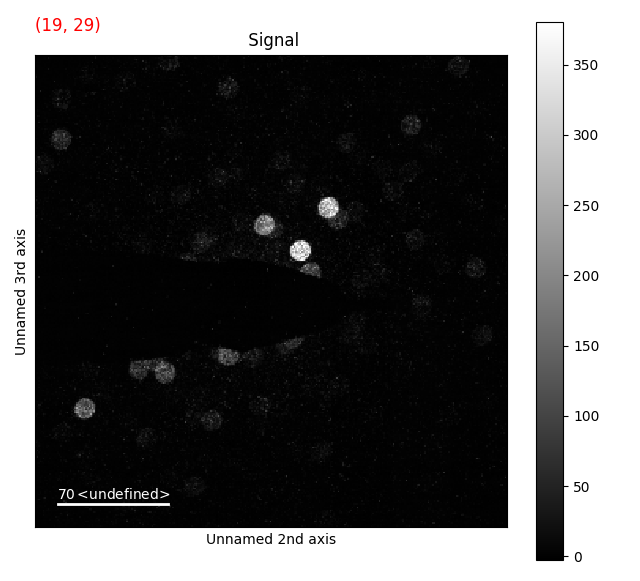

In [10]:
# dataset = np.einsum('klij->lkij', dataset) # swap the first to dimensions for better visulization
s = hs.signals.Signal2D(data=dataset)
s.transpose()
s.plot()

In [ ]:
rx = 150
ry = 150
refpath = '/srv/home/chenyu/DEbackup/092219/S0_10kX/npy/'
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'
dataset = np.zeros((110,16,1024,1024))
dataset_ref = np.zeros((110,16,1024,1024))

# load reference frame
irow = 0
icol = 130
nSample = irow * rx + icol + 1;
Sample_ref = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
num_rows, num_cols = Sample_ref.shape[:2]

# loop over all beam positions in the ROI
for irow in range(110):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(130,145):
        nSample = irow * rx + icol + 1;
        Sample = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
        corr = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(Sample_ref)*np.fft.fft2(Sample))).real
        y, x = np.unravel_index(np.argmax(corr), corr.shape)
        x = x - 572
        y = y - 673 # calculate relative shift
#         print(x,y)
        translation_matrix = np.float32([[1,0,-x],[0,1,-y]])
        # Also keep all the blank scan frames inside a datacube so that one can check whether the registration is correct
        dataset_ref[irow,icol-130,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))
        
        # load CBED with sample and correct for the shift
        Sample = np.load(path + 'S2_'+format(nSample,'05')+'.npy')
        dataset[irow,icol-130,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))

## Register all frames according to top left pixel

In [12]:
rx = 150
ry = 150
refpath = '/srv/home/chenyu/DEbackup/092219/S0_10kX/npy/'
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'
dataset = np.zeros((110,16,1024,1024))
dataset_ref = np.zeros((110,16,1024,1024))

# load reference frame
irow = 0
icol = 130
nSample = irow * rx + icol + 1;
Sample_ref = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
num_rows, num_cols = Sample_ref.shape[:2]

# loop over all beam positions in the ROI
for irow in range(110):
    if irow%10 == 0:
        print('Now working on row '+str(irow))
    for icol in range(130,145):
        nSample = irow * rx + icol + 1;
        Sample = np.load(refpath+'S0_'+format(nSample,'05')+'.npy')
        corr = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(Sample_ref)*np.fft.fft2(Sample))).real
        y, x = np.unravel_index(np.argmax(corr), corr.shape)
        x = x - 572
        y = y - 673 # calculate relative shift
#         print(x,y)
        translation_matrix = np.float32([[1,0,-x],[0,1,-y]])
        # Also keep all the blank scan frames inside a datacube so that one can check whether the registration is correct
        dataset_ref[irow,icol-130,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))
        
        # load CBED with sample and correct for the shift
        Sample = np.load(path + 'S2_'+format(nSample,'05')+'.npy')
        dataset[irow,icol-130,:,:] = cv2.warpAffine(Sample, translation_matrix, (num_cols, num_rows))

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100


In [13]:
np.save('/srv/home/chenyu/DEbackup/092219/S2/ROI1_registered.npy',dataset)
np.save('/srv/home/chenyu/DEbackup/092219/S2/ROI1_ref_registered.npy',dataset_ref)

<IPython.core.display.Javascript object>


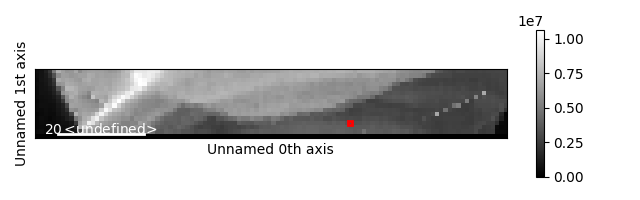

<IPython.core.display.Javascript object>


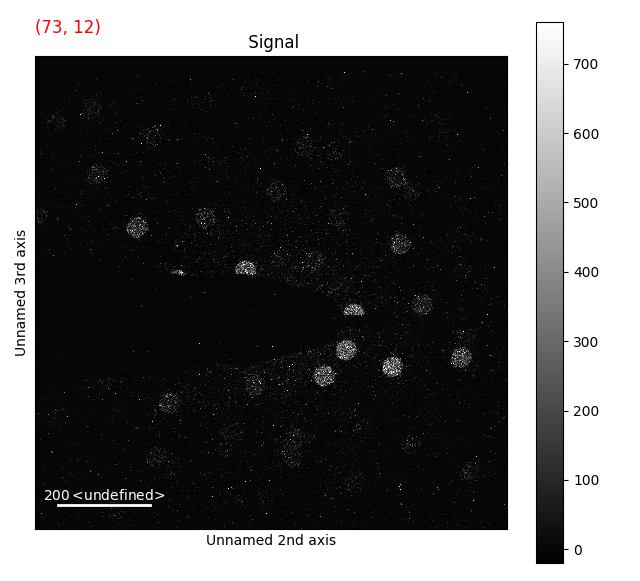

In [82]:
%matplotlib notebook
import hyperspy.api as hs
dataset = np.einsum('klij->lkij', dataset) # swap the first to dimensions for better visulization
s = hs.signals.Signal2D(data=dataset)
s.transpose()
s.plot()

<IPython.core.display.Javascript object>


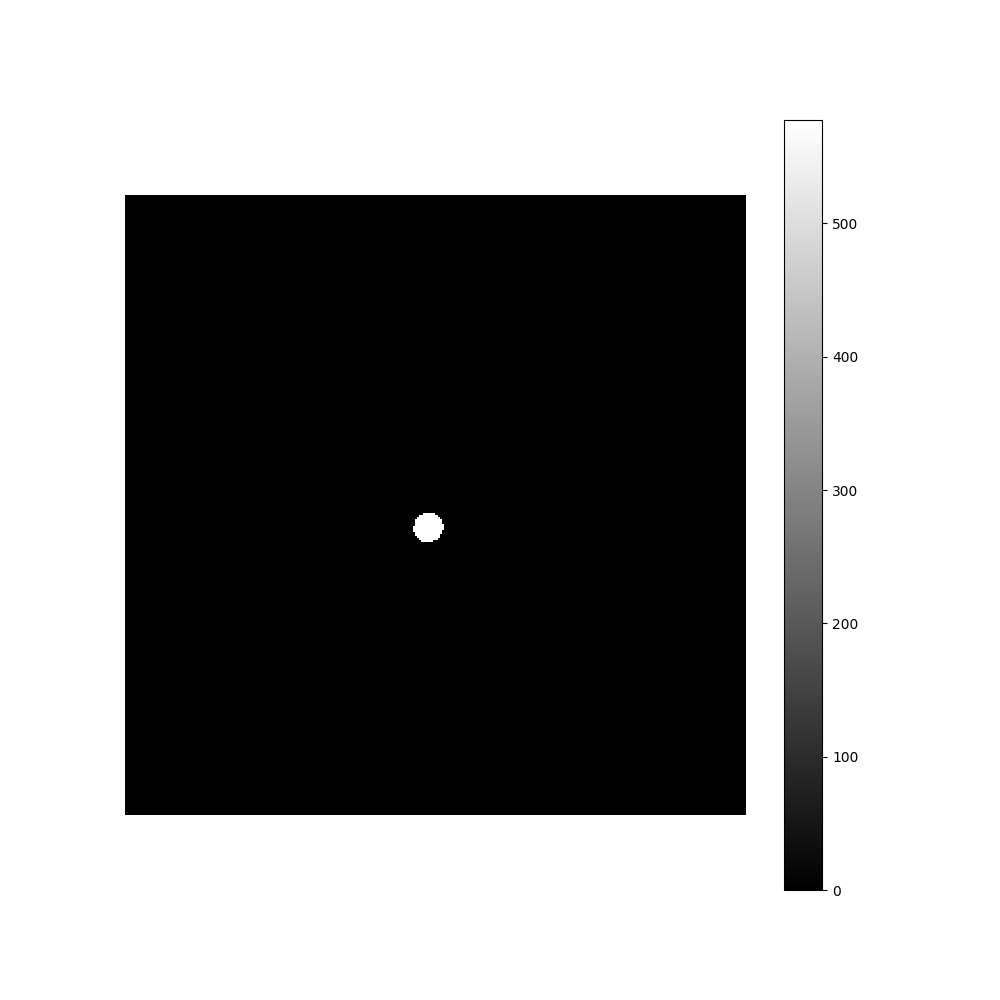

(-0.5, 299.5, 299.5, -0.5)

In [182]:
dataset = np.load('/srv/home/chenyu/DEbackup/092219/S2/Thin_registered.npy')
PACBED = np.sum(np.sum(dataset,axis=0),axis=0)
fig = plt.figure(figsize=(10,10))
# plt.imshow(PACBED,clim=[0,100000])
PACBED[PACBED<0] = 0
plt.imshow(np.sqrt(PACBED))
plt.colorbar()
plt.axis('off')

In [183]:
# Try simple cross correlation
# extract xcorr mask
dataset_ref = np.load('/srv/home/chenyu/DEbackup/092219/S2/Thin_ref_registered.npy')
mask = np.sum(np.sum(dataset_ref,axis=0),axis=0)
# plt.imshow(mask)
# plt.colorbar()
mask = np.heaviside(mask-50000,1)

# Can generate a ring-shaped mask using morphological gradient
# kernel = np.ones((2,2),np.uint8)
# mask = cv2.morphologyEx(mask,cv2.MORPH_GRADIENT,kernel)
# mask = mask[530:630,500:600]
plt.imshow(mask)

<IPython.core.display.Javascript object>


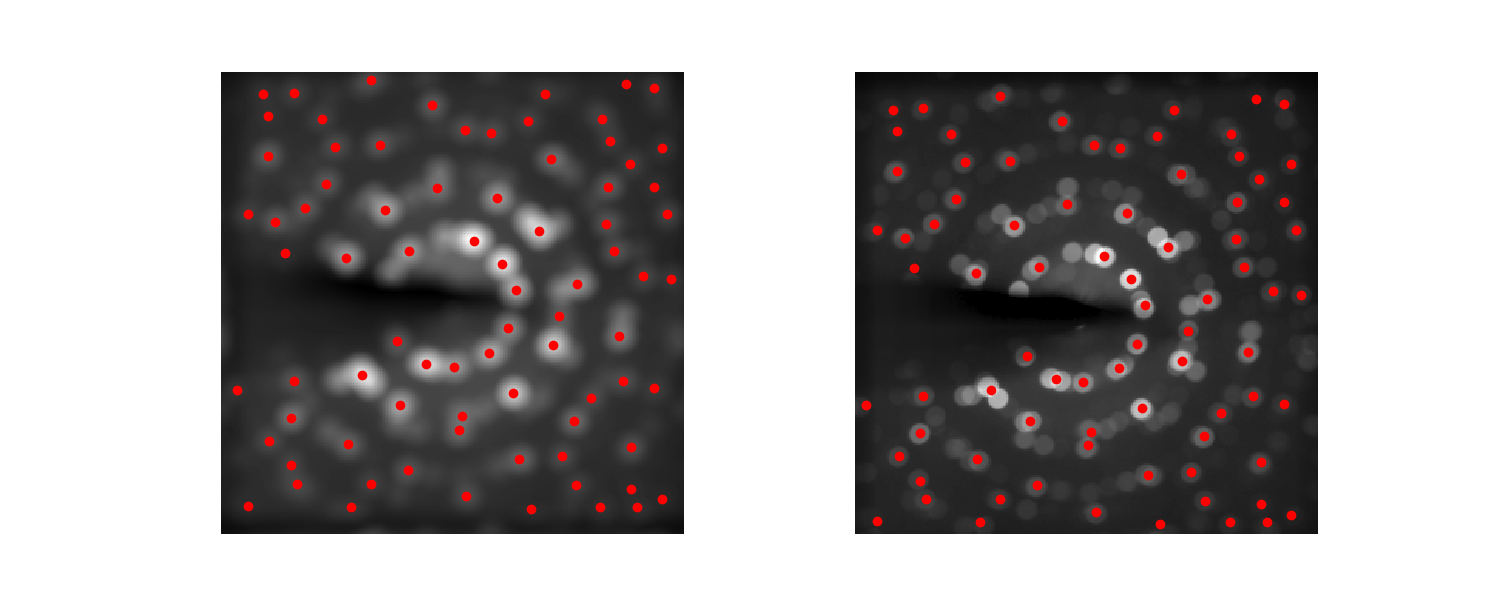

(-0.5, 299.5, 299.5, -0.5)

In [193]:
mask_pad = mask
PACBED_pad = PACBED
# mask_pad = np.pad(mask_pad,[(100,100),(100,100)],mode='constant')
# PACBED_pad = np.pad(PACBED_pad,[(100,100),(100,100)],mode = 'constant')

corr = (np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(mask_pad))*np.fft.fft2(PACBED_pad)))).real

fig = plt.figure(figsize=(15,6))

fig.add_subplot(121)
plt.imshow(np.sqrt(corr))
image_max = ndi.maximum_filter(corr, size=5, mode='nearest')
coordinates = peak_local_max(corr, min_distance=5)
plt.scatter(coordinates[:,1],coordinates[:,0],c='r')
plt.axis('off')

fig.add_subplot(122)
plt.imshow(np.sqrt(PACBED))
# There is a constant shift on the detected peak positions, basically because the mask is not centered
plt.scatter(coordinates[:,1]-3,coordinates[:,0]+10,c='r')
coordinates_total = coordinates
plt.axis('off')

In [69]:
print(coordinates_total)

[[854 653]
 [851 754]
 [824 268]
 [797 237]
 [756 529]
 [739 391]
 [709 644]
 [661 298]
 [650 514]
 [641 443]
 [620 589]
 [603 731]
 [593 387]
 [581 884]
 [566 634]
 [546 513]
 [540 889]
 [537 749]
 [487 651]
 [480 756]
 [421 625]
 [391 420]
 [373 565]
 [362 497]
 [353 712]
 [333 858]
 [305 366]
 [300 185]
 [278 612]
 [278 414]
 [259 480]
 [192 742]]


<IPython.core.display.Javascript object>


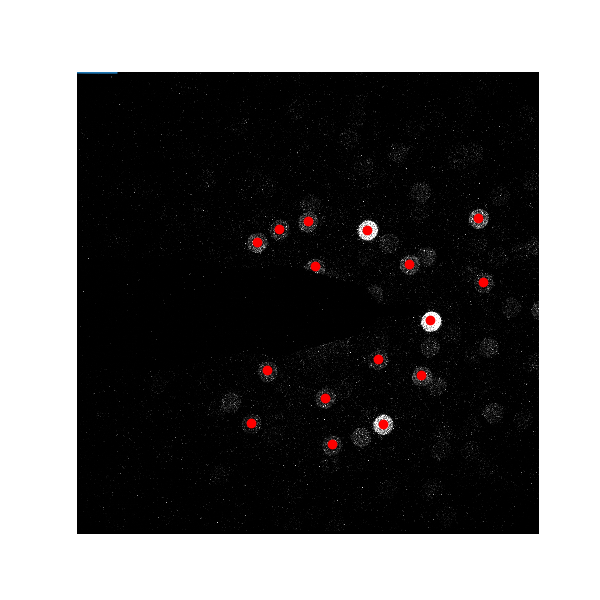

(-0.5, 1023.5, 1023.5, -0.5)

In [127]:
temp = dataset[16,10,:,:]
corr = (np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(mask_pad))*np.fft.fft2(temp)))).real
image_max = ndi.maximum_filter(corr, size=15, mode='nearest')
coordinates = peak_local_max(corr, min_distance=15,threshold_rel=0.10)

fig = plt.figure(figsize=(6,6))
plt.imshow(temp,clim=[0,500])
plt.scatter(coordinates[:,1]+35,coordinates[:,0]+70,c='r')
plt.axis('off')

In [128]:
temp = dataset[16,10,:,:]
input_mat = np.zeros((len(coordinates_total),dataset.shape[0]*dataset.shape[1]))
for irow in range(dataset.shape[0]):
    for icol in range(dataset.shape[1]):
        temp = dataset[irow,icol,:,:]
        nSample = irow * dataset.shape[1] + icol
        corr = (np.fft.fftshift(np.fft.ifft2(np.conjugate(np.fft.fft2(mask_pad))*np.fft.fft2(temp)))).real
#         plt.imshow(corr)
#         plt.colorbar()
        image_max = ndi.maximum_filter(corr, size=15, mode='nearest')
        coordinates = peak_local_max(corr, min_distance=15,threshold_rel=0.10)
#         plt.scatter(coordinates[:,1],coordinates[:,0],c='r')
#         print(nSample)
        for i in range(len(coordinates_total)):
            coordinates_temp = coordinates - coordinates_total[i]
            dist = np.sqrt(np.square(coordinates_temp[:,0]) + np.square(coordinates_temp[:,1]))
#             print(np.amin(dist))
            if coordinates.any():
                if np.amin(dist) < 5:
                    input_mat[i,nSample] = 1

In [129]:
np.save('/srv/home/chenyu/DEbackup/092219/S2/ROI1_binarized_0.1threshold_allpeaks.npy',input_mat)

<IPython.core.display.Javascript object>


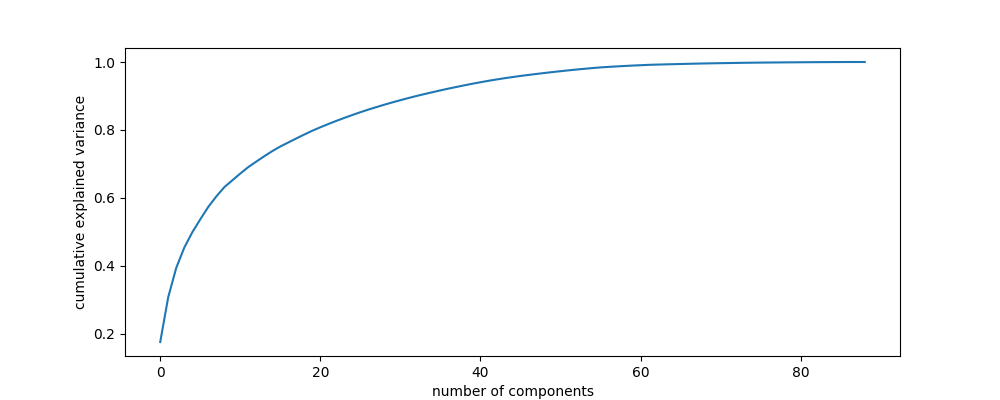

In [131]:
from sklearn.decomposition import PCA
pca = PCA().fit(np.transpose(input_mat))
fig = plt.figure(figsize=(10,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

<IPython.core.display.Javascript object>


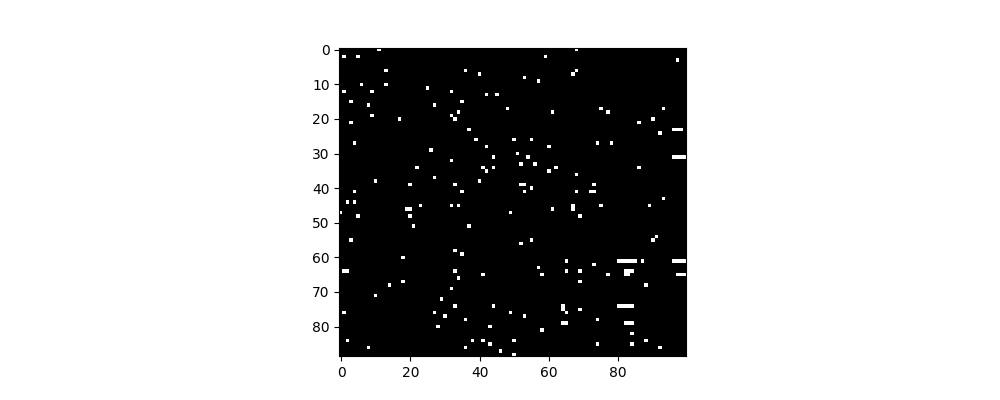

In [132]:
fig = plt.figure(figsize=(10,4))
plt.imshow(input_mat[:,0:100])

In [133]:
pca = PCA(10)
pca.fit(np.transpose(input_mat))
print(pca.components_.shape) # pca_components contains the new feature matrix
score_mat = pca.transform(np.transpose(input_mat)) # score_mat is the loading matrix
print(score_mat.shape)

(10, 89)
(1760, 10)


In [53]:
DF = np.sum(np.sum(dataset,axis=2),axis=2)

<IPython.core.display.Javascript object>


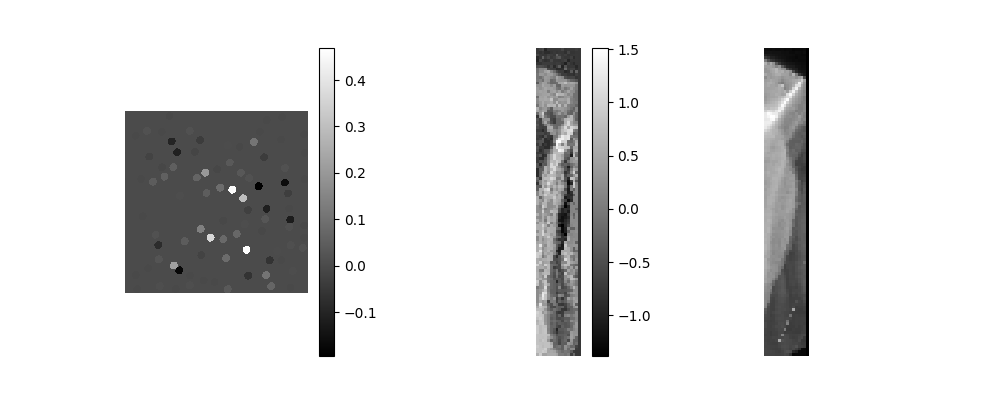

(-0.5, 15.5, 109.5, -0.5)

In [138]:
# visulize pca component together with loading map
icomponent = 3
component_map = np.zeros((1024,1024))
for i in range(len(pca.components_[icomponent,:])):
    x = coordinates_total[i,0]
    y = coordinates_total[i,1]
    component_map[x,y] = pca.components_[icomponent,i]
    
# visulize pca components
fig = plt.figure(figsize=(10,4))
fig.add_subplot(131)
corr = (np.fft.fftshift(np.fft.ifft2(np.fft.fft2(mask)*np.fft.fft2(component_map)))).real
plt.imshow(corr)
plt.colorbar()
plt.axis('off')

temp = score_mat[:,icomponent]
temp_reshape = np.reshape(temp,(110,16))

# visulize loading map
fig.add_subplot(132)
plt.imshow(temp_reshape)
plt.colorbar()
plt.axis('off')

# plot simple DF image
fig.add_subplot(133)
plt.imshow(DF)
plt.axis('off')

## Test Hough transform from edge detection

<IPython.core.display.Javascript object>


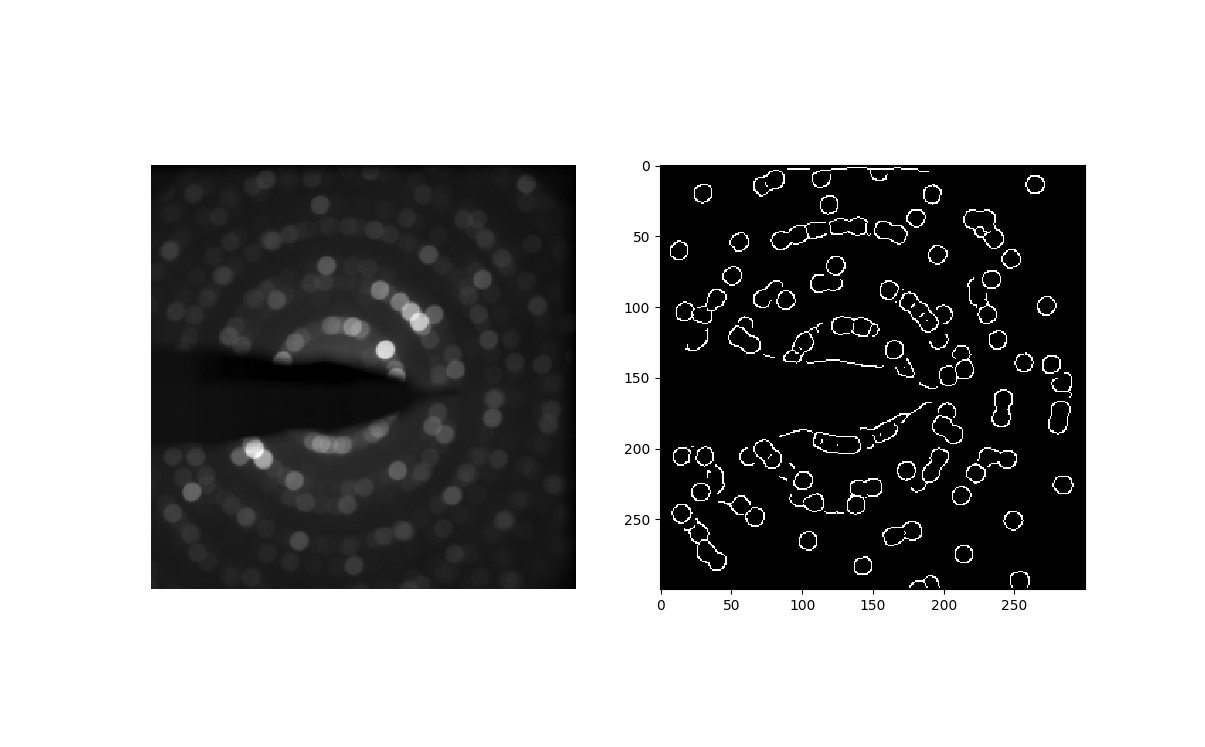

In [136]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk
from skimage.feature import canny

dataset = np.load('/srv/home/chenyu/DEbackup/092219/S2/ROI2_registered.npy')
PACBED = np.sum(np.sum(dataset,axis=0),axis=0)

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
# selem = disk(4)
temp = PACBED
temp[temp<0]=0
plt.imshow(np.sqrt(temp))
plt.axis('off')
# plt.colorbar()

fig.add_subplot(122)
temp = closing(PACBED, selem)
temp = PACBED
plt.imshow(canny(np.sqrt(temp),sigma=2,low_threshold=10,high_threshold=50))

<IPython.core.display.Javascript object>


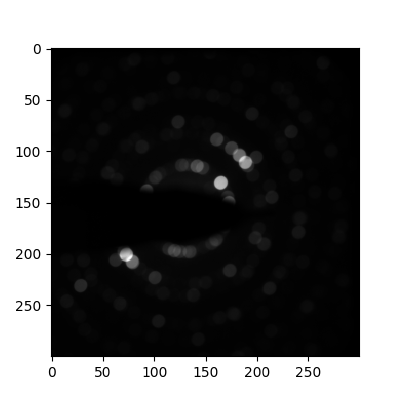

In [100]:
fig = plt.figure(figsize=(4,4))
PACBED = PACBED / np.amax(PACBED) * 1
image = color.gray2rgb(PACBED)
plt.imshow(image)

<IPython.core.display.Javascript object>


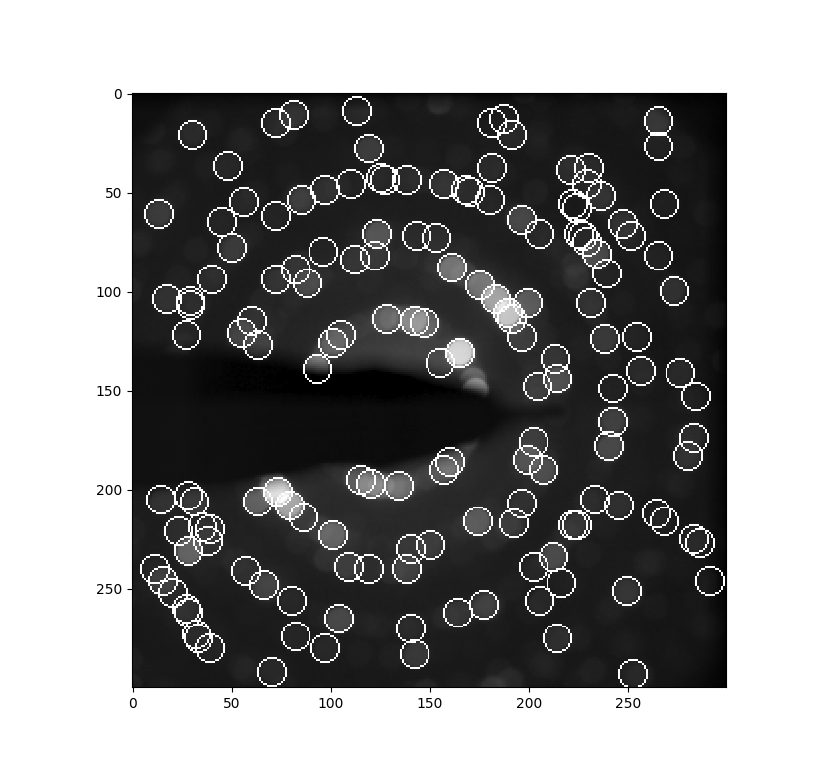

In [163]:
# Test Hough Transform to find circles
edges = canny(np.sqrt(temp),sigma=0,low_threshold=0,high_threshold=70)

# Detect two radii
hough_radii = np.arange(7,8,1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# print(cx,cy,radii)
# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
PACBED_norm = PACBED / np.amax(PACBED)
PACBED_norm[PACBED_norm<0] = 0
PACBED_norm = np.sqrt(PACBED_norm)
image = color.gray2rgb(PACBED_norm)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

[133 134 132 134 132] [157 158 158 156 156] [6 5 5 5 5]
133 157 5


<IPython.core.display.Javascript object>


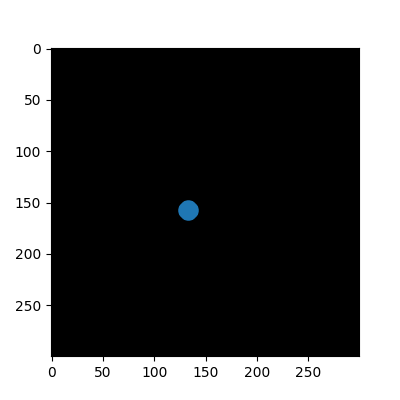

In [66]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Test Hough Transform to find circles
edges = canny(mask)
temp = edges.astype('uint8')
hough_radii = np.arange(5,30,1)
hough_res = hough_circle(temp, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=5)
print(cx,cy,radii)

image = color.gray2rgb(mask)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)

fig = plt.figure(figsize=(4,4))
circy, circx = circle_perimeter(cy,cx,radii)
plt.imshow(image)
plt.scatter(circx, circy)

## Generate video

In [75]:
path = '/srv/home/chenyu/DEbackup/092219/S2/npy/'
pathOut = '/srv/home/chenyu/DEbackup/092219/S2/video.avi'
fps=0.1
frame_array = []
files = [f for f in os.listdir(path)]
files.sort(key = lambda x: x[3:-4])

In [128]:
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 20
video_filename = pathOut
out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

# new frame after each addition of water
for i in range(1000):
    img = np.load(path + files[i])
    img[img>700] = 700
    #add this array to the video
    gray = cv2.resize(img,dsize=(512,512),interpolation=cv2.INTER_CUBIC)
    gray = cv2.normalize(img, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)   # normalize image
    gray_3c = cv2.merge([gray, gray, gray])
    out.write(gray_3c)

# close out the video writer
out.release()

S2_00011.npy


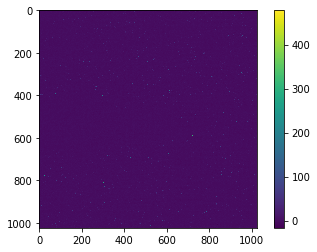

In [123]:
i=10
img = np.load(path + files[i])
# img = np.resize(img,(512,512))
print(files[i])
img[img>700] = 700
plt.imshow(img)
# plt.clim([0,700])
plt.colorbar()

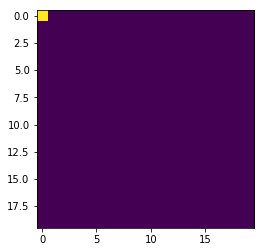

In [122]:
test = np.zeros((20,20))
test[9,9]=1
corr = np.fft.ifft2(np.conjugate(np.fft.fft2(test))*np.fft.fft2(test))
plt.imshow(corr.real)